<a href="https://colab.research.google.com/github/fjpena35226/q-learning/blob/main/frozen-lake/FrozenLake_tuto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install gymnasium
!pip install tf-agents[reverb]

In this post we'll compare a bunch of different map sizes on the
[FrozenLake](https://gymnasium.farama.org/environments/toy_text/frozen_lake/)_
environment from the reinforcement learning
[Gymnasium](https://gymnasium.farama.org/)_ using the Q-learning
algorithm.




In [3]:
%matplotlib inline


# Frozenlake benchmark


## Dependencies




Let's first import a few dependencies we'll need.




In [4]:
# Author: Andrea Pierré, Francisco Peña
# License: MIT License

import tensorflow as tf

tf.executing_eagerly()

print(tf.__version__)


from pathlib import Path
from typing import NamedTuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

import gymnasium as gym
from gymnasium.envs.toy_text.frozen_lake import generate_random_map
from gymnasium.wrappers import TimeLimit

from IPython.display import clear_output


sns.set_theme()

# %load_ext lab_black

2.14.0


In [5]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)
gpuName = 'device:GPU:0' if gpus != None else None

[]


## Parameters we'll use




In [6]:
total_episodes=3000
learning_rate=0.8
gamma=0.95
epsilon=0.1
map_size=4
seed=123
is_slippery=False
n_runs=20
action_size=None
state_size=None
proba_frozen=0.9
savefig_folder=Path("/content/drive/MyDrive/q-learning/frozen_lake")
save_model_path = "/content/drive/MyDrive/q-learning/frozen_lake/model/"

# Set the seed
rng = np.random.default_rng(seed)

# Create the figure folder if it doesn't exists
savefig_folder.mkdir(parents=True, exist_ok=True)

## Visualization




To make it easy to plot the results with Seaborn, we'll save the main
results of the simulation in Pandas dataframes.




In [7]:
def postprocess(episodes, rewards, steps, map_size, n_runs):
    """Convert the results of the simulation in dataframes."""
    res = pd.DataFrame(
        data={
            "Episodes": np.tile(episodes, reps=n_runs),
            "Rewards": rewards.flatten(),
            "Steps": steps.flatten(),
        }
    )
    res["cum_rewards"] = rewards.cumsum(axis=0).flatten(order="F")
    res["map_size"] = np.repeat(f"{map_size}x{map_size}", res.shape[0])

    st = pd.DataFrame(data={"Episodes": episodes, "Steps": steps.mean(axis=1)})
    st["map_size"] = np.repeat(f"{map_size}x{map_size}", st.shape[0])
    return res, st

We want to plot the policy the agent has learned in the end. To do that
we will: 1. extract the best Q-values from the Q-table for each state,
2. get the corresponding best action for those Q-values, 3. map each
action to an arrow so we can visualize it.




In [8]:
def qtable_directions_map(qtable, map_size):
    """Get the best learned action & map it to arrows."""
    qtable_val_max = qtable.max(axis=1).reshape(map_size, map_size)
    qtable_best_action = np.argmax(qtable, axis=1).reshape(map_size, map_size)
    directions = {0: "←", 1: "↓", 2: "→", 3: "↑"}
    qtable_directions = np.empty(qtable_best_action.flatten().shape, dtype=str)
    eps = np.finfo(float).eps  # Minimum float number on the machine
    for idx, val in enumerate(qtable_best_action.flatten()):
        if qtable_val_max.flatten()[idx] > eps:
            # Assign an arrow only if a minimal Q-value has been learned as best action
            # otherwise since 0 is a direction, it also gets mapped on the tiles where
            # it didn't actually learn anything
            qtable_directions[idx] = directions[val]
    qtable_directions = qtable_directions.reshape(map_size, map_size)
    return qtable_val_max, qtable_directions

With the following function, we'll plot on the left the last frame of
the simulation. If the agent learned a good policy to solve the task, we
expect to see it on the tile of the treasure in the last frame of the
video. On the right we'll plot the policy the agent has learned. Each
arrow will represent the best action to choose for each tile/state.




In [9]:
def plot_q_values_map(qtable, env, map_size):
    """Plot the last frame of the simulation and the policy learned."""
    qtable_val_max, qtable_directions = qtable_directions_map(qtable, map_size)

    # Plot the last frame
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
    ax[0].imshow(env.render())
    ax[0].axis("off")
    ax[0].set_title("Last frame")

    # Plot the policy
    sns.heatmap(
        qtable_val_max,
        annot=qtable_directions,
        fmt="",
        ax=ax[1],
        cmap=sns.color_palette("Blues", as_cmap=True),
        linewidths=0.7,
        linecolor="black",
        xticklabels=[],
        yticklabels=[],
        annot_kws={"fontsize": "xx-large"},
    ).set(title="Learned Q-values\nArrows represent best action")
    for _, spine in ax[1].spines.items():
        spine.set_visible(True)
        spine.set_linewidth(0.7)
        spine.set_color("black")
    img_title = f"frozenlake_q_values_{map_size}x{map_size}.png"
    fig.savefig(savefig_folder / img_title, bbox_inches="tight")
    plt.show()

In [10]:
def show_last_frame(env):
  # Plot the last frame
  plt.imshow(env.render())

  plt.axis('off')
  plt.show()

In [11]:
def render_env(env, title):
  clear_output(wait=True)
  plt.imshow(env.render())
  plt.axis('off')
  plt.show()

As a sanity check, we will plot the distributions of states and actions
with the following function:




In [12]:
def plot_states_actions_distribution(states, actions, map_size):
    """Plot the distributions of states and actions."""
    labels = {"LEFT": 0, "DOWN": 1, "RIGHT": 2, "UP": 3}

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    sns.histplot(data=states, ax=ax[0], kde=True)
    ax[0].set_title("States")
    sns.histplot(data=actions, ax=ax[1])
    ax[1].set_xticks(list(labels.values()), labels=labels.keys())
    ax[1].set_title("Actions")
    fig.tight_layout()
    img_title = f"frozenlake_states_actions_distrib_{map_size}x{map_size}.png"
    fig.savefig(savefig_folder / img_title, bbox_inches="tight")
    plt.show()

## Helpers

In [13]:
def int_to_grid(integer, grid_shape=(4,4)):
    """
    Function to map an integer to it's 2D grid location

    E.g. to place the integer 5 in a 4x4 (height*width) grid

            0000
    5   ->  0100
            0000
            0000

    Steps:
    1) np.prod(grid_shape) i.e. 4*4=16
    2) np.identity(16)[integer:integer+1] i.e. output something like [0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0]
    3) np.reshape(grid_shape) i.e. output the grid form of the above
    """
    return np.identity(np.prod(grid_shape))[integer:integer+1].reshape(grid_shape)

## The FrozenLake environment




### Qlearning Agent

In this tutorial we'll be using Q-learning as our learning algorithm and
$\epsilon$-greedy to decide which action to pick at each step. You
can have a look at the [References section](#References)_ for some
refreshers on the theory. Now, let's create our Q-table initialized at
zero with the states number as rows and the actions number as columns.




In [19]:
class QlearningAgent:
    def __init__(self,  epsilon, learning_rate, gamma, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.reset_qtable()
        self.epsilon = epsilon

    def act(self, action_space, state, qtable):
      """Choose an action `a` in the current world state (s)."""
      # First we randomize a number
      explor_exploit_tradeoff = rng.uniform(0, 1)
      # Exploration
      if explor_exploit_tradeoff < self.epsilon:
          action = action_space.sample()
      # Exploitation (taking the biggest Q-value for this state)
      else:
          # Break ties randomly
          # If all actions are the same for this state we choose a random one
          # (otherwise `np.argmax()` would always take the first one)
          if np.all(qtable[state, :]) == qtable[state, 0]:
              action = action_space.sample()
          else:
              action = np.argmax(qtable[state, :])
      return action

    def update(self, state, action, reward, new_state):
        """Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]"""
        delta = (
            reward
            + self.gamma * np.max(self.qtable[new_state, :])
            - self.qtable[state, action]
        )
        q_update = self.qtable[state, action] + self.learning_rate * delta
        return q_update

    def reset_qtable(self):
        """Reset the Q-table."""
        self.qtable = np.zeros((self.state_size, self.action_size))

#### Running env with QlearningAgent



In [23]:
def run_env(env, agent, n_runs, total_episodes):
    rewards = np.zeros((total_episodes, n_runs))
    steps = np.zeros((total_episodes, n_runs))
    episodes = np.arange(total_episodes)
    qtables = np.zeros((n_runs, agent.state_size, agent.action_size))
    all_states = []
    all_actions = []

    for run in range(n_runs):  # Run several times to account for stochasticity
        agent.reset_qtable()  # Reset the Q-table between runs

        for episode in tqdm(
            episodes, desc=f"Run {run}/{n_runs} - Episodes", leave=False
        ):
            state = env.reset(seed=seed)[0]  # Reset the environment
            step = 0
            done = False
            total_rewards = 0

            while not done:
                action = agent.act(
                    action_space=env.action_space, state=state, qtable=agent.qtable
                )

                # Log all states and actions
                all_states.append(state)
                all_actions.append(action)

                # Take the action (a) and observe the outcome state(s') and reward (r)
                new_state, reward, terminated, truncated, info = env.step(action)

                done = terminated or truncated

                agent.qtable[state, action] = agent.update(
                    state, action, reward, new_state
                )

                total_rewards += reward
                step += 1

                # Our new state is state
                state = new_state

            # Log all rewards and steps
            rewards[episode, run] = total_rewards
            steps[episode, run] = step
        qtables[run, :, :] = agent.qtable

    return rewards, steps, episodes, qtables, all_states, all_actions

#### Training

In [25]:
res_all = pd.DataFrame()
st_all = pd.DataFrame()

def solve_map(map_size, n_runs, total_episodes):
    env = gym.make(
        "FrozenLake-v1",
        is_slippery=is_slippery,
        render_mode="rgb_array",
        desc=generate_random_map(
            size=map_size, p=proba_frozen, seed=seed
        ),
    )

    env.action_space.seed(
        seed
    )  # Set the seed to get reproducible results when sampling the action space
    agent = QlearningAgent(
        learning_rate=learning_rate,
        epsilon=epsilon,
        gamma=gamma,
        state_size=env.observation_space.n,
        action_size=env.action_space.n,
    )

    print(f"Map size: {map_size}x{map_size}")
    rewards, steps, episodes, qtables, all_states, all_actions = run_env(env, agent, n_runs, total_episodes)

    # Save the results in dataframes
    res, st = postprocess(episodes, rewards, steps, map_size, n_runs)
    l_res_all = pd.concat([res_all, res])
    l_st_all = pd.concat([st_all, st])
    qtable = qtables.mean(axis=0)  # Average the Q-table between runs

    plot_states_actions_distribution(
        states=all_states, actions=all_actions, map_size=map_size
    )  # Sanity check
    plot_q_values_map(qtable, env, map_size)

    env.close()
    return l_res_all, l_st_all

Now we'll be running our agent on a few increasing maps sizes: -
$5 \times 5$, - $10 \times 10$, - $15 \times 15$

Putting it all together:




Map size: 5x5


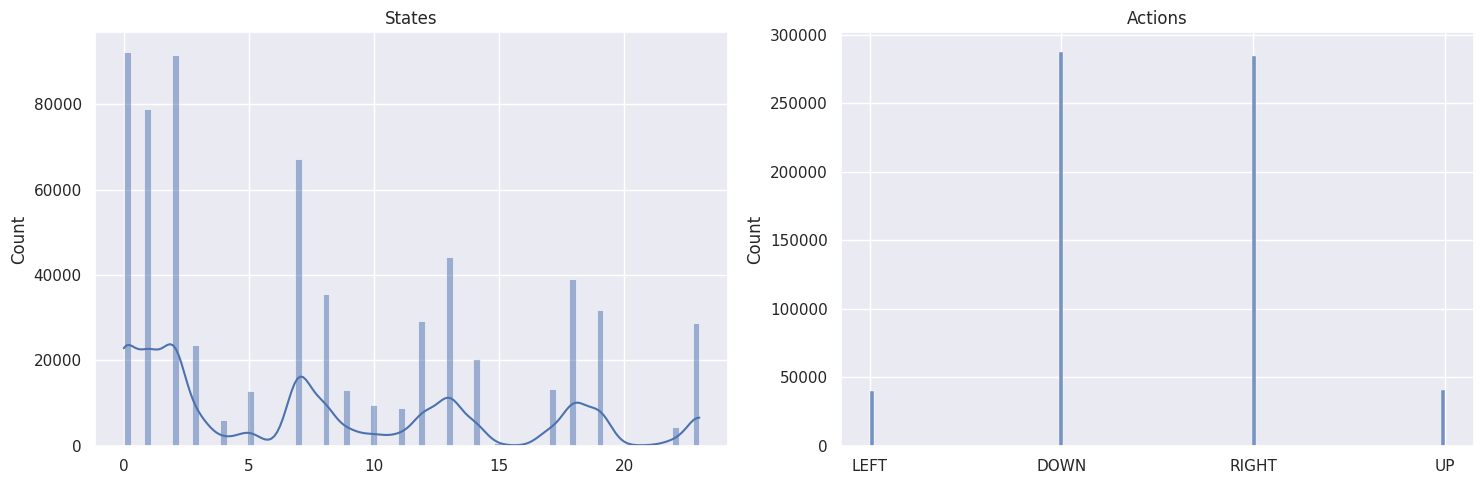

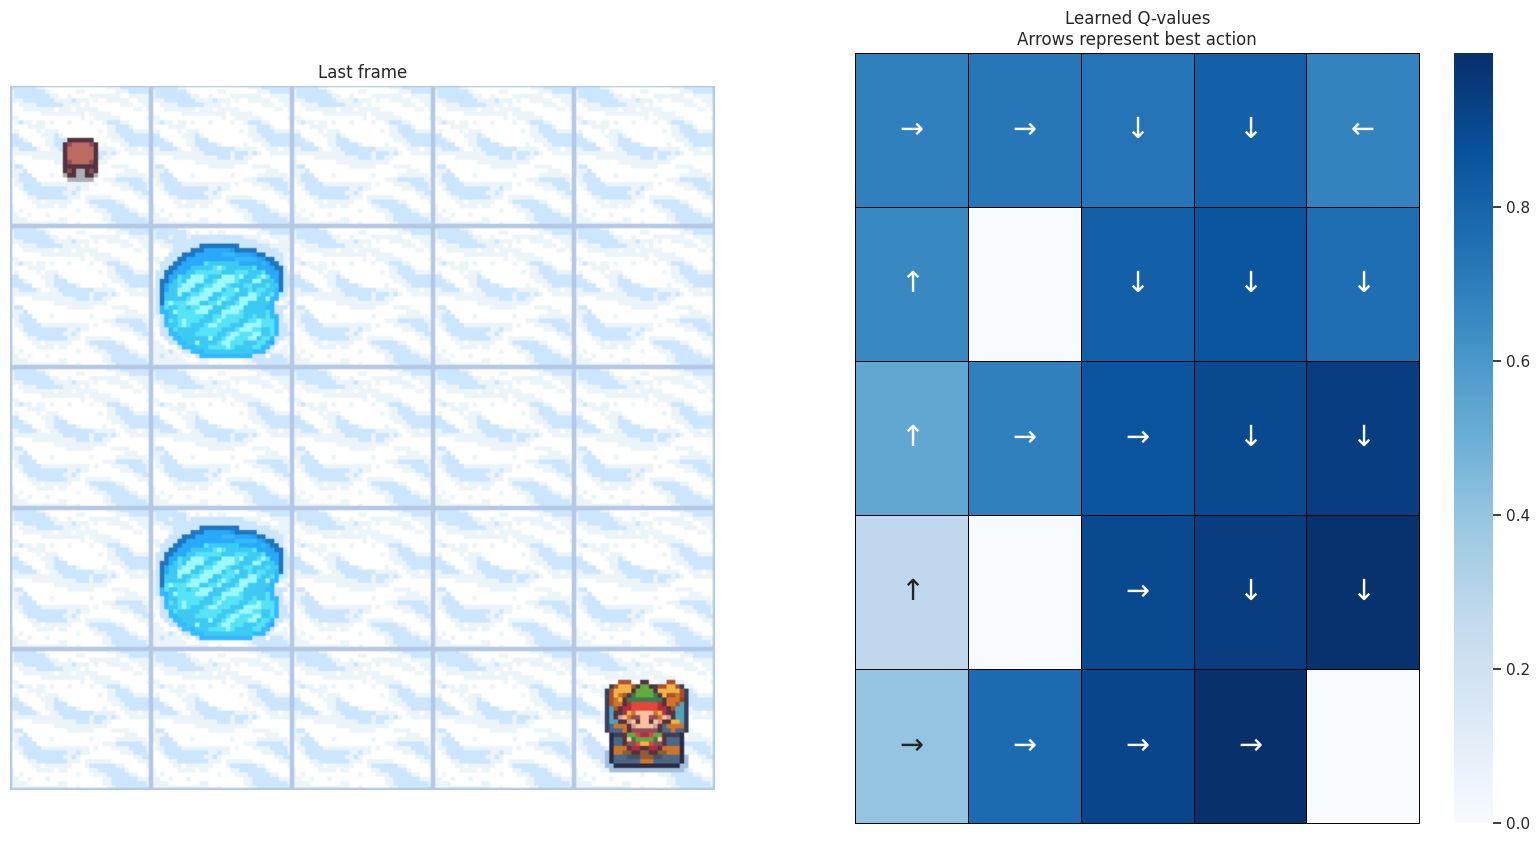

Map size: 10x10


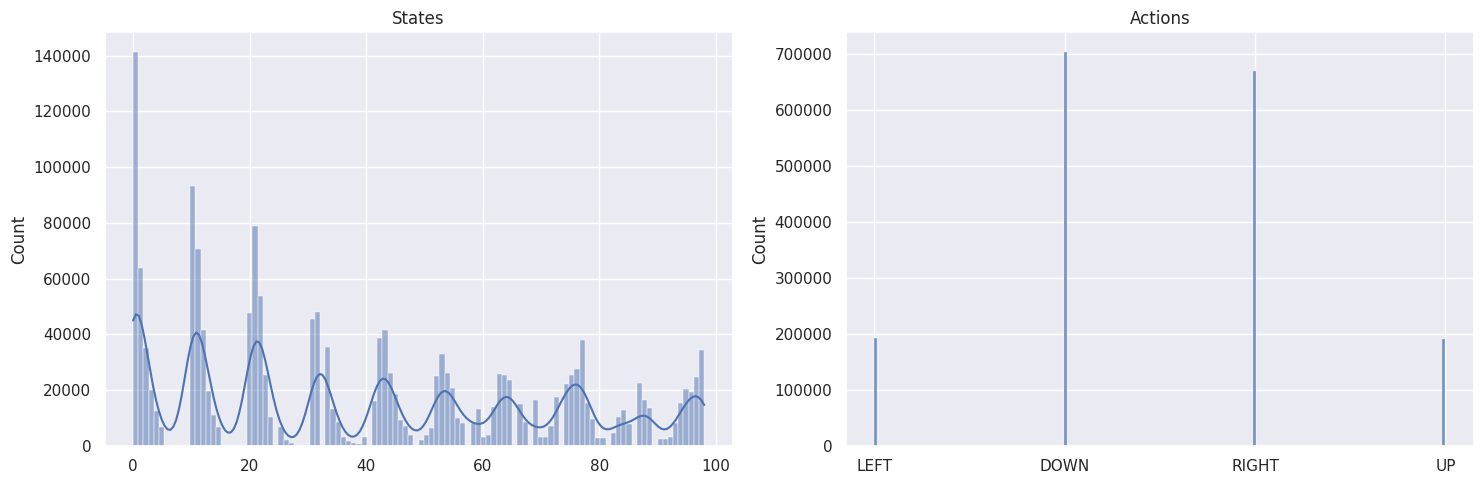

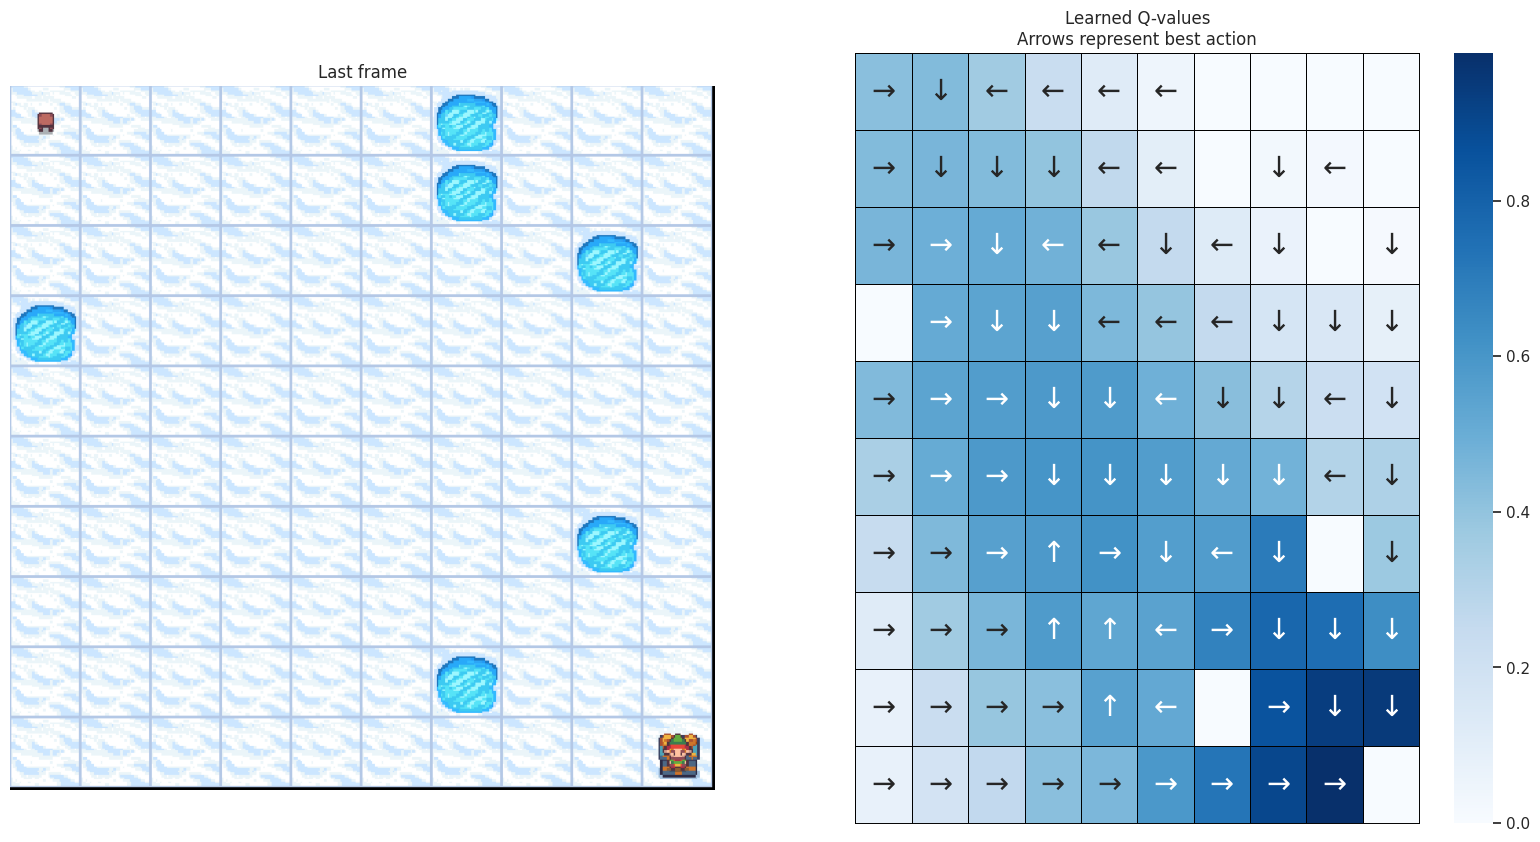

Map size: 15x15


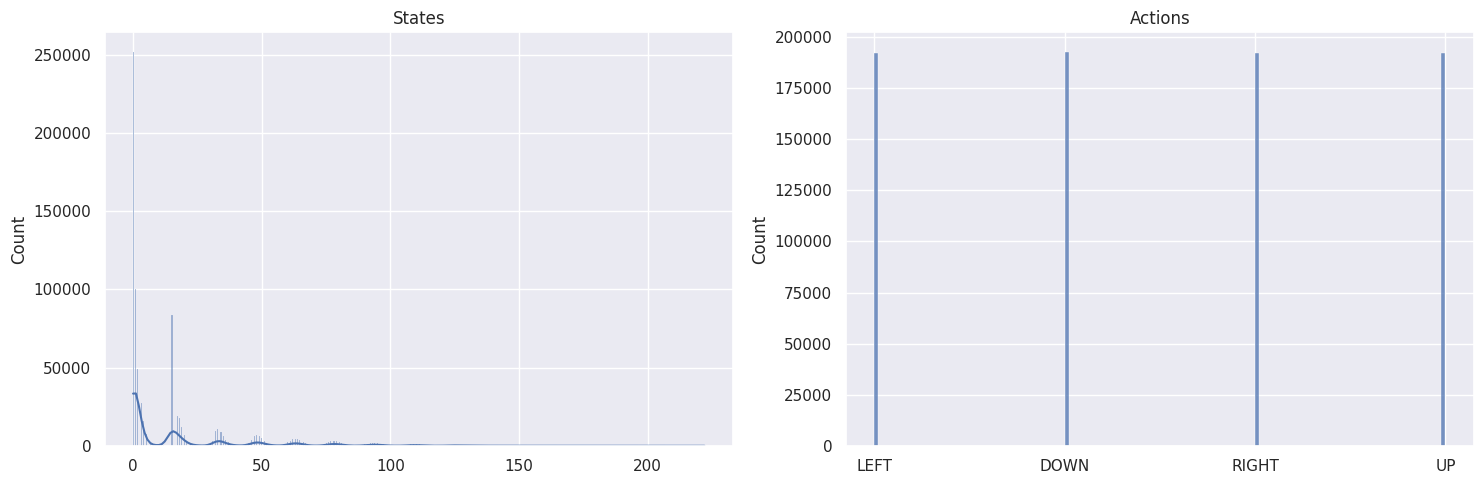

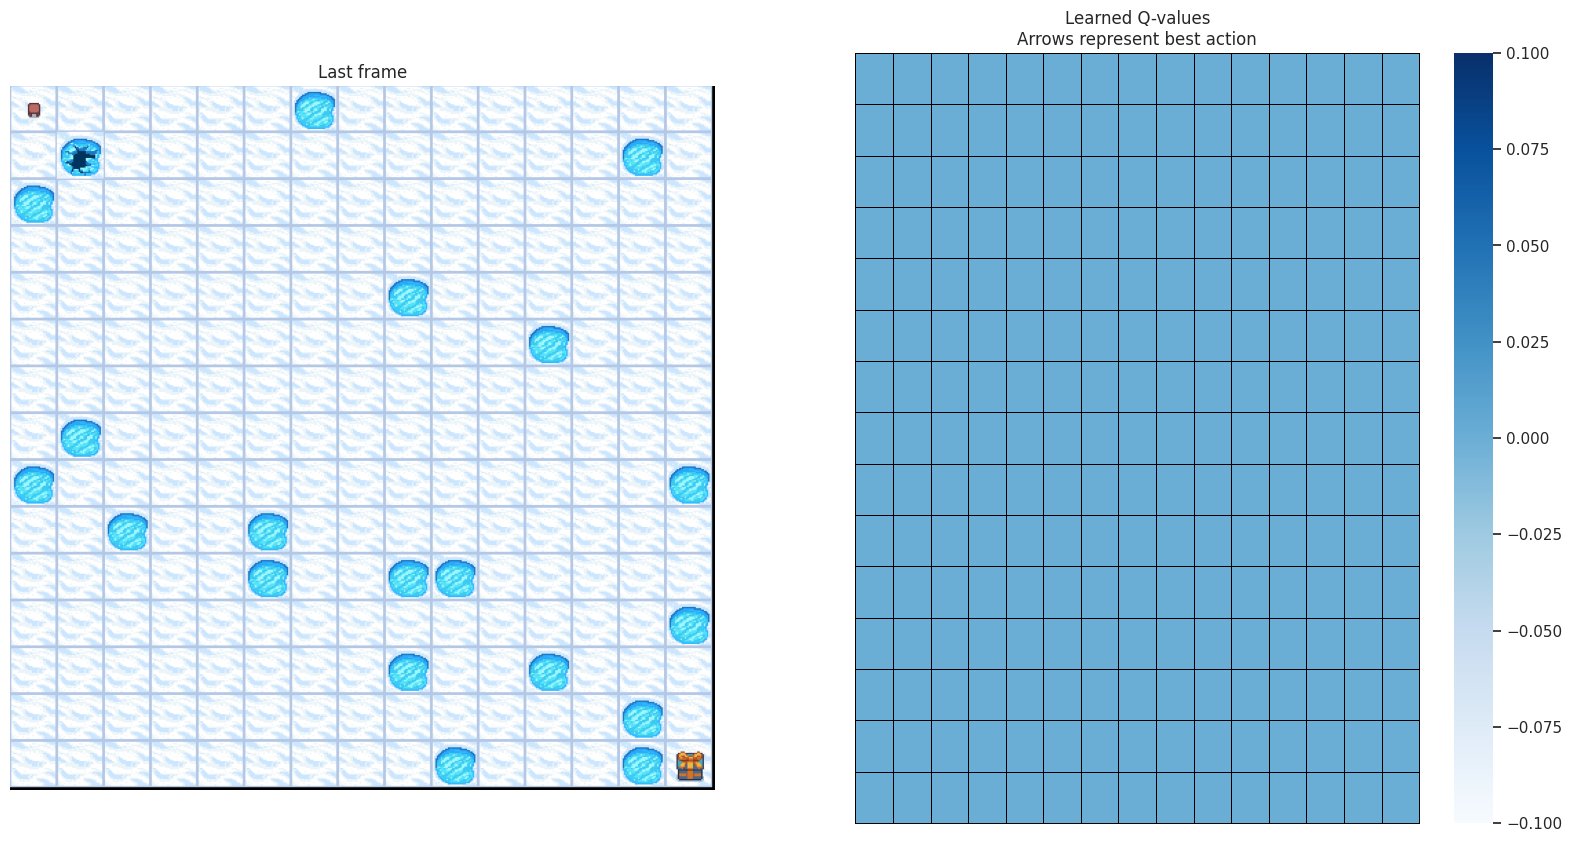

In [26]:
map_sizes = [5, 10, 15]

for map_size in map_sizes:
  res_all, st_all = solve_map(map_size, n_runs, total_episodes = 4000)

It looks like the agent isn't quite capable of solving a 15x15 map size with the current number of runs. Lets add more runs.

Map size: 15x15


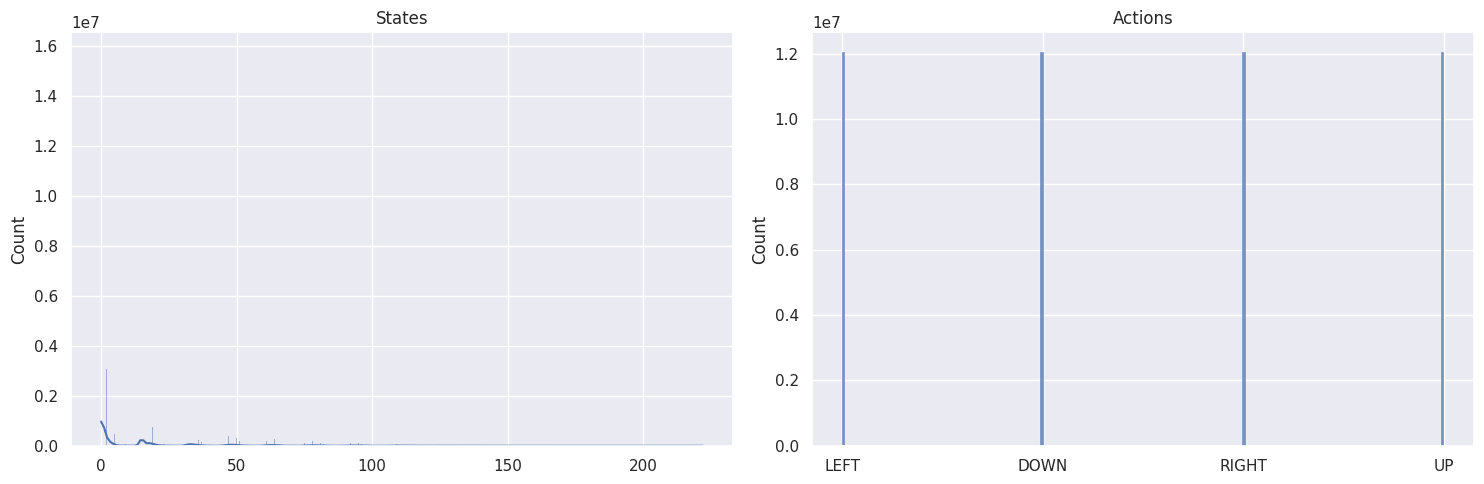

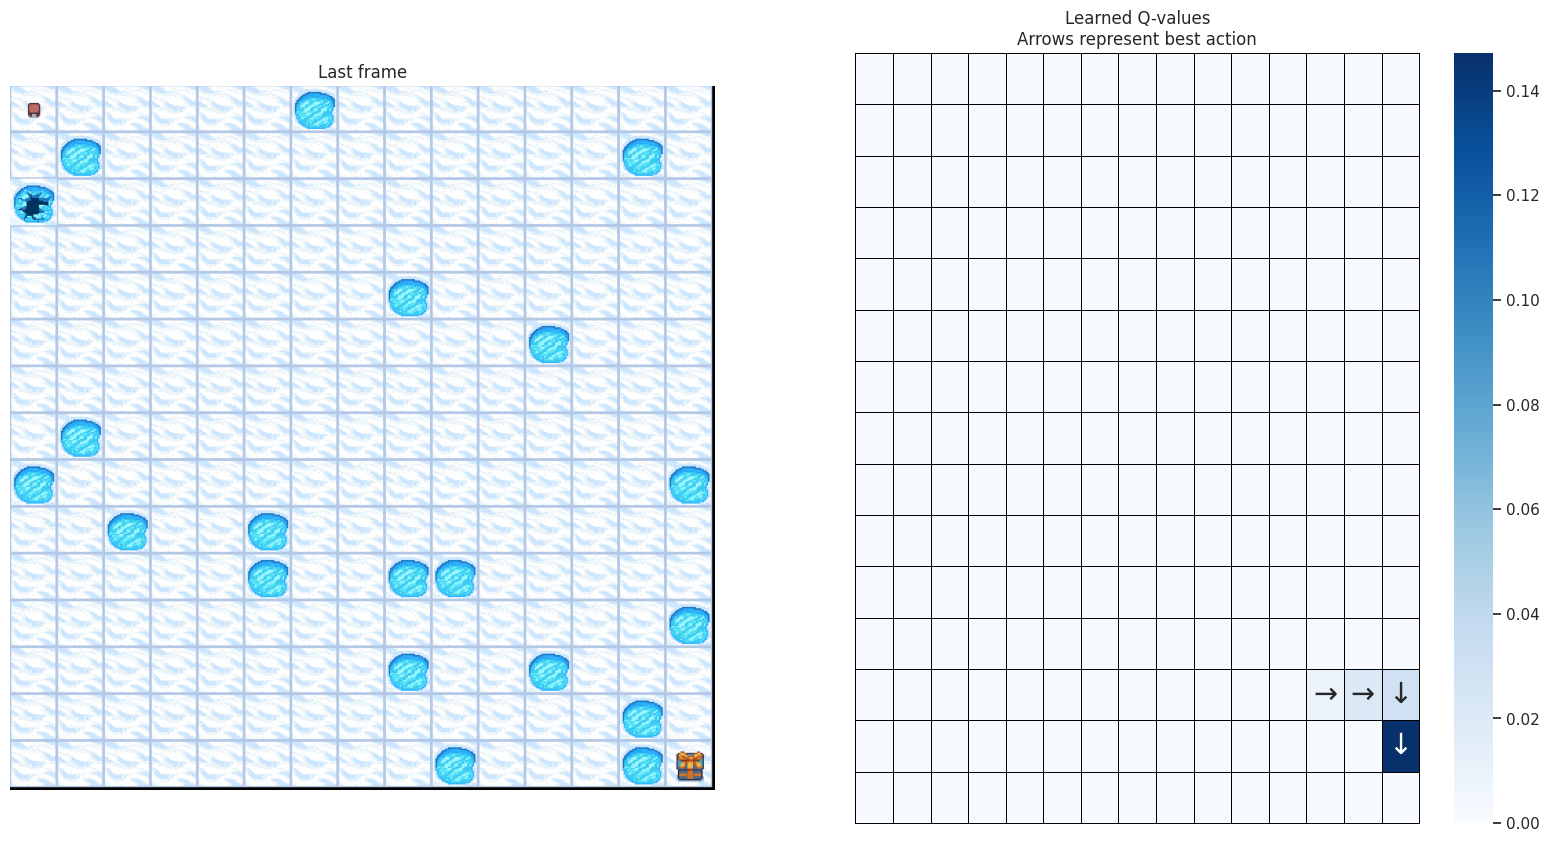

In [29]:
res_all, st_all = solve_map(15, n_runs = 50, total_episodes = 100000)

### Deep Q-learning Agent

This section is still work in progress

#### DQL Agent

In [40]:
import random
import numpy as np
from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  Dense, Input, LSTM, Bidirectional, Reshape, Flatten, SeparableConv2D, Embedding
from tensorflow.keras.optimizers import Adam

class DQNAgent:
    def __init__(
        self,
        input_shape,
        observation_space,
        action_space,
        map_size,
        layers_spec     = (100, 50),
        memory_size     = 100,
        gamma           = 0.95,  # discount rate
        epsilon         = 1.0,   # exploration rate
        epsilon_min     = 0.1,
        epsilon_decay   = 0.9999,
        learning_rate   = 0.001,
    ):
        self.input_shape      =input_shape
        self.observation_space=observation_space
        self.map_size        = map_size
        self.action_space    = action_space
        self.memory          = []
        self.layers_spec     = layers_spec
        self.memory_size     = memory_size
        self.gamma           = gamma
        self.epsilon         = epsilon
        self.epsilon_min     = epsilon_min
        self.epsilon_decay   = epsilon_decay
        self.learning_rate   = learning_rate
        self.model           = self.build_model()
        self.target_model    = self.build_model()
        self.update_target_model()

    def simple_nn(self):
        # Neural Net for Deep-Q learning Model
        model = tf.keras.Sequential()
        model.add(Input(shape=self.input_shape))
        for num_units in self.layers_spec:
          model.add(
              Dense(
                  num_units,
                  activation='relu',
                  kernel_initializer=tf.keras.initializers.VarianceScaling(
                    scale=2.0,
                    mode='fan_in',
                    distribution='truncated_normal'
                  )
              )
          )

        model.add(
            Dense(
              self.action_space.n,
              activation=None,
              kernel_initializer=tf.keras.initializers.RandomUniform(
                  minval=-0.03, maxval=0.03),
              bias_initializer=tf.keras.initializers.Constant(-0.2)
            )
        )

        model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=self.learning_rate, epsilon=1e-7))
        #model.summary()
        return model

    def lstm_nn(self):
        # Neural Net for Deep-Q learning Model
        model = tf.keras.Sequential()
        model.add(Embedding(self.observation_space.n + 1, 64, input_length=self.observation_space.n))
        model.add(Bidirectional(LSTM(16, return_sequences=True)))
        model.add(Flatten())
        model.add(Dense(self.action_space.n, activation='softmax'))

        model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=self.learning_rate, epsilon=1e-7))
        #model.summary()
        return model

    def build_model(self):
        return self.simple_nn()

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def clear_memory(self):
        del self.memory
        self.memory = []

    def state_2d_scalar(self, state):
      return np.identity(np.prod(self.input_shape))[state:state+1].reshape(self.input_shape)

    def state_scalar(self, state):
        zeros = np.zeros(self.observation_space.n)
        zeros[state] = 1
        return zeros

    def process_state(self, state):
        return self.state_scalar(state)

    def memorize(self, state, action, reward, next_state, done):
        if(len(self.memory) >= self.memory_size - 1):
          removed = [self.memory.pop(random.randrange(len(self.memory))) for _ in range(1)]
        scaled_state = self.process_state(state)
        scaled_next_state = self.process_state(next_state)
        self.memory.append((scaled_state, action, reward, scaled_next_state, done))

    def act(self, state):
        # First we randomize a number
        explor_exploit_tradeoff = rng.uniform(0, 1)

        if explor_exploit_tradeoff < self.epsilon:
          action = self.action_space.sample()
        else:
          scaled_state = self.process_state(state)
          act_values = self.model.predict(np.expand_dims(scaled_state, axis=0), verbose=0)
          if np.all(act_values[0] == act_values[0][0]):
            action = self.action_space.sample()
          else:
            action = np.argmax(act_values[0])
        return action

    def internal_replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        states = np.array([exp[0] for exp in minibatch])
        next_states = np.array([exp[3] for exp in minibatch])

        targets = self.model.predict(states, verbose = 0)
        next_targets = self.target_model.predict(next_states, verbose = 0)

        for index, experience in enumerate(minibatch):
            state, action_index, reward, next_state, done = experience
            if done:
              targets[index][action_index] = reward
            else:
              """Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]"""
              delta = (
                    reward
                    + self.gamma * np.amax(next_targets[index])
                    - targets[index][action_index]
                )
              targets[index][action_index] = targets[index][action_index] + self.learning_rate * delta
            #print(f"{state} => {targets[index]}")

        self.model.fit(states, np.array(targets), epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def replay(self, batch_size):
        if gpus:
          for gpu in gpus:
            with tf.device(gpuName):
              self.internal_replay(batch_size)
        else:
            self.internal_replay(batch_size)

    def get_q_table(self):
      ep = self.epsilon
      qtable = []
      scaled_states = []
      for state in range(self.observation_space.n):
        scaled_states.append(self.process_state(state))
      qtable = self.model.predict(np.array(scaled_states), verbose = 0)
      return np.array(qtable)


    def load(self, name):
        self.model.load_weights(name)
        self.update_target_model()

    def save(self, name):
        self.target_model.save_weights(name)

#### Running env with DQNAgent

In [41]:
def run_env_dqn(
      env,
      agent,
      n_runs,
      total_episodes,
      training_batch_size,
      model_name,
      update_target_model_frequency,
      save_training_frequency,
      render=False
    ):
    rewards = np.zeros((total_episodes, n_runs))
    steps = np.zeros((total_episodes, n_runs))
    episodes = np.arange(total_episodes)
    all_states = []
    all_actions = []

    for run in range(n_runs):
      agent.clear_memory();
      for episode in tqdm(
            episodes, desc=f"Run {run}/{n_runs} - Episodes", leave=False
        ):
          state = env.reset(seed=seed)[0]  # Reset the environment
          size = agent.observation_space.n
          step = 0
          done = False
          total_rewards = 0

          while not done:
              action = agent.act(state)

              # Log all states and actions
              all_states.append(state)
              all_actions.append(action)

              # Take the action (a) and observe the outcome state(s') and reward (r)
              new_state, reward, done, truncated, info = env.step(action)

              reward =  0 if (new_state == state) or (done and new_state < size and not truncated) else new_state / size if not done else reward

              terminated = done or truncated

              #directions = {0: "←", 1: "↓", 2: "→", 3: "↑"}
              #print(f"state: {state}, action: {directions[action]}, reward: {reward}, new_state: {new_state}, done: {done}")

              agent.memorize(state, action, reward, new_state, done)

              total_rewards += reward

              if terminated or total_rewards < 0:
                break
              if len(agent.memory) > training_batch_size:
                agent.replay(training_batch_size)

              step += 1

              # Our new state is state
              state = new_state

              if render:
                render_env(env, 'Episode: {}'.format(episode))

              if episode > 0 and episode % save_training_frequency == 0:
                agent.save(save_model_path + model_name +'_{}.h5'.format(episode))

          # Log all rewards and steps
          rewards[episode, run] = total_rewards
          steps[episode, run] = step

    return rewards, steps, episodes, all_states, all_actions

#### Training

In [42]:
res_all = pd.DataFrame()
st_all = pd.DataFrame()

def create_train_agent(
      map_size, n_runs,
      total_episodes,
      max_episode_steps=False,
      training_batch_size = 32,
      model_name = 'agent',
      update_target_model_frequency = 5,
      save_training_frequency = 100,
      load_model=False
    ):
    env = gym.make(
        "FrozenLake-v1",
        is_slippery=is_slippery,
        render_mode="rgb_array",
        desc=generate_random_map(
            size=map_size, p=proba_frozen, seed=seed
        ),
    )

    if max_episode_steps != False:
      env = TimeLimit(env, max_episode_steps=max_episode_steps)

    env.action_space.seed(
        seed
    )  # Set the seed to get reproducible results when sampling the action space

    agent = DQNAgent(
        input_shape=(map_size * map_size,),
        memory_size=map_size * map_size,
        learning_rate=learning_rate,
        epsilon=epsilon,
        gamma=gamma,
        action_space=env.action_space,
        observation_space=env.observation_space,
        map_size = map_size,
    )

    if load_model != False:
      agent.load(load_model)

    print(f"Map size: {map_size}x{map_size}")
    rewards, steps, episodes, all_states, all_actions = run_env_dqn(
        env,
        agent,
        n_runs,
        total_episodes,
        training_batch_size,
        model_name,
        update_target_model_frequency,
        save_training_frequency
    )

    # Save the results in dataframes
    res, st = postprocess(episodes, rewards, steps, map_size, n_runs)
    l_res_all = pd.concat([res_all, res])
    l_st_all = pd.concat([st_all, st])

    qtable = agent.get_q_table()

    plot_states_actions_distribution(
        states=all_states, actions=all_actions, map_size=map_size
    )  # Sanity check
    plot_q_values_map(qtable, env, map_size)

    env.close()
    return agent, env

#### Create and train

In [ ]:
agent, env = create_train_agent(map_size = 5, n_runs=1, training_batch_size=16, model_name='nn_agent_5x5', total_episodes = 2000)

Map size: 5x5


Run 0/1 - Episodes:  42%|████▏     | 830/2000 [3:09:59<6:25:24, 19.76s/it]

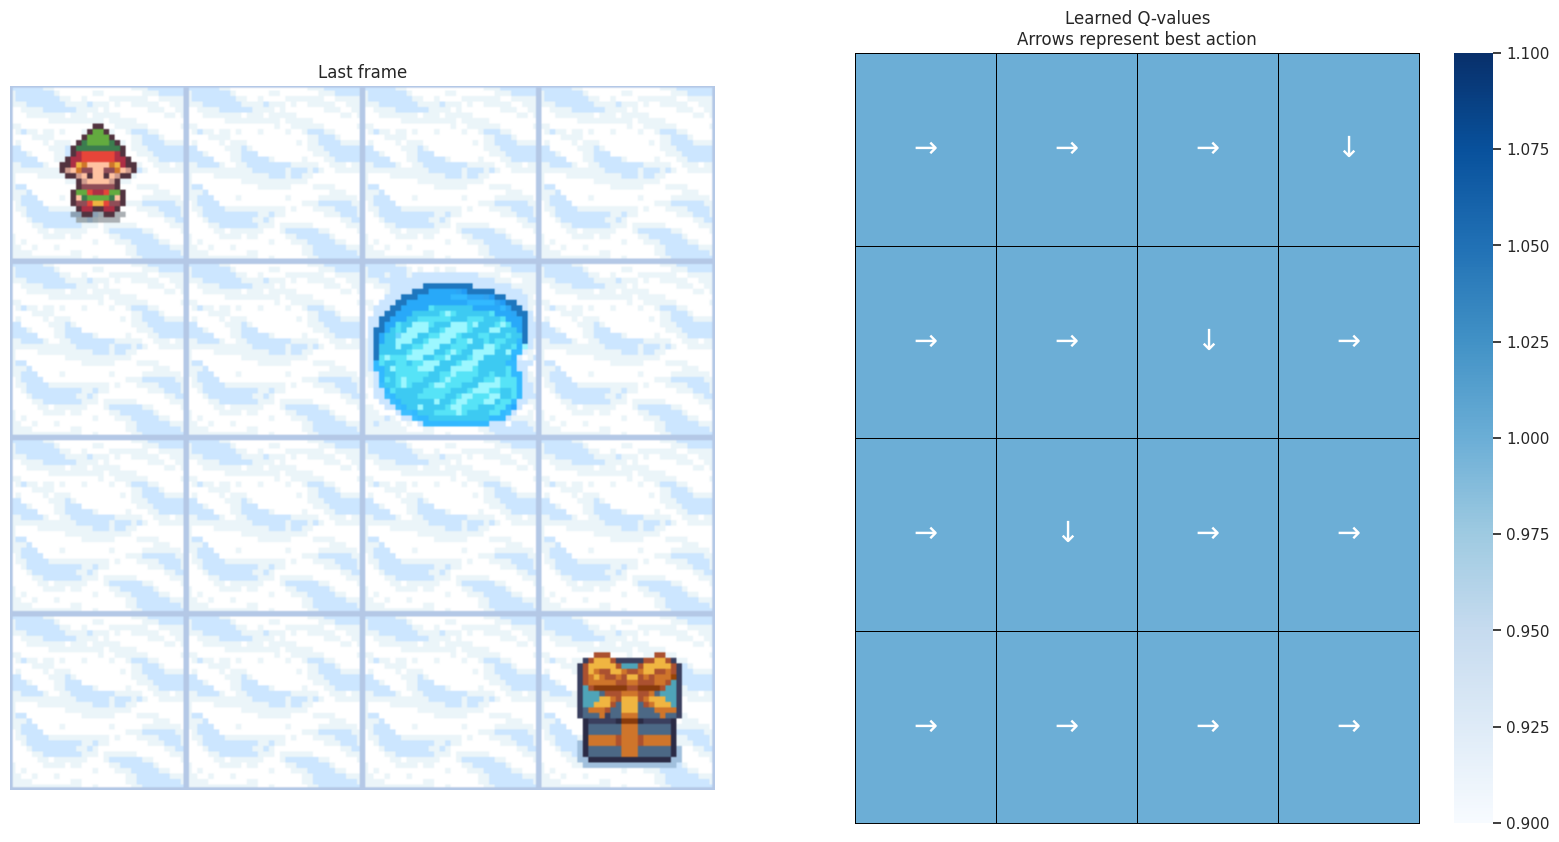

In [18]:
map_size = 4

env = gym.make(
  "FrozenLake-v1",
  is_slippery=is_slippery,
  render_mode="rgb_array",
  desc=generate_random_map(
      size=map_size, p=proba_frozen, seed=seed
  ),
)

env.reset()

agent = DQNAgent(
    input_shape=(map_size * map_size,),
    learning_rate=learning_rate,
    epsilon=0,
    gamma=gamma,
    action_space=env.action_space,
    observation_space=env.observation_space,
    map_size = map_size,
)

agent.load(save_model_path + 'agent_4x4_1600.h5')

plot_q_values_map(agent.get_q_table(), env, map_size)

#### Auto solving

In [43]:
def try_to_solve(env, agent, episodes):
  agent.epsilon = 0
  for e in range(episodes):
    done = False
    state, info = env.reset()
    while not done:
      action = agent.act(state)
      new_state, reward, terminated, truncated, info = env.step(action)
      done = terminated or truncated
      state = new_state
      render_env(env, 'Episode: {}'.format(e))

In [ ]:
try_to_solve(env, agent, 4)